In [42]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import datetime

In [27]:
df = pd.read_csv('data/cc_data.csv')
df = df[:1000]

In [28]:
df = df[['Normalized Retailer','SIC Description','Purchase Amount']]
df.columns

Index(['Normalized Retailer', 'SIC Description', 'Purchase Amount'], dtype='object')

In [62]:
retailer_list = list(df['Normalized Retailer'].unique())
print(retailer_list[:20])
print("Numbers of retailers: %d" % len(retailer_list))

['Red Robin', 'California Thai', 'Petro-Canada', 'The Beer Store', 'Intermarche', "Harvey's", 'Pet Valu', 'Bc Liquor Stores', 'Amazon', 'Fas Gas', 'Esso', "Wendy's", 'Tim Hortons', 'H Mart', 'KFC', "Mac's Convenience Store", 'Subway', 'Metro', "McDonald's", 'Canadian Tire Store']
Numbers of retailers: 226


In [64]:
SIC_list = list(df['SIC Description'].unique())
print(SIC_list[:10])
print("Numbers of SIC: %d" % len(SIC_list))

['Eating Places', 'Gasoline Service Stations', 'Liquor Stores', 'Grocery Stores', 'Optical Goods Stores', 'Book Stores', 'Variety Stores', 'Hardware Stores', 'Communications Services, Not Elsewhere Classified', 'Taxicabs']
Numbers of SIC: 46


In [65]:
df_group = df.groupby('SIC Description').agg(lambda x: x.unique().tolist())
df_group.head()

,Normalized Retailer,Purchase Amount
SIC Description,,
Amusement Parks,[Canada's Wonderland],[112.2]
"Bands, Orchestras, Actors, and Other Entertainers and Entertainment Groups",[Patreon],"[2.69, 20.32]"
Book Stores,"[Amazon, Indigo, Scholastic Canada Ltd., Coles]","[24.8, 9.03, 4.55, 154.16, 23.3, 14.15, 18.97,..."
Bowling Centers,[Playdium],[30.51]
Children's and Infants' Wear Stores,"[Children's Place, Play It Again Sports]","[53.46, 0.2, 22.59]"


In [67]:
training_data = df_group['Normalized Retailer'].tolist()
print(training_data[:10])

[["Canada's Wonderland"], ['Patreon'], ['Amazon', 'Indigo', 'Scholastic Canada Ltd.', 'Coles'], ['Playdium'], ["Children's Place", 'Play It Again Sports'], ['Netflix', 'Rogers'], ['Microsoft', 'Mc Afee', 'Intuit', 'Canada Computers'], ['Reuters.Com', 'Apple'], ['Canada Post', 'DHL'], ['Marble Slab Creamery']]


In [68]:
start = datetime.datetime.now()

model = Word2Vec(sentences = training_data, # list of sets of retailers
                 iter = 5, # epoch
                 min_count = 1, # a retailer has to appear more than min_count times to be kept
                 size = 3, # hidden layer dimensions
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Model training time: " + str(datetime.datetime.now()-start))

Model training time: 0:00:00.106711


In [81]:
# check dictionary
for i, word in enumerate(model.wv.vocab):
    if i == 10:
        break
    print(word)

Canada's Wonderland
Patreon
Amazon
Indigo
Scholastic Canada Ltd.
Coles
Playdium
Children's Place
Play It Again Sports
Netflix


In [91]:
# check vector given a certain word from the dictionary
print(model.wv['Amazon'])

[-0.00489882  0.02249223  0.14729287]


In [88]:
# calculate similarity between two words
pairs = [
    ("Netflix", "Rogers"), 
    ("Netflix", "Children's Place"),   
    ("Play It Again Sports", "Children's Place"), 
]
print("Similarity comparison\n")
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

Similarity comparison

'Netflix'	'Rogers'	-0.98
'Netflix'	"Children's Place"	-0.56
'Play It Again Sports'	"Children's Place"	0.84


In [89]:
# find out most similar terms
print(model.wv.most_similar(positive=['Amazon'], topn=3))

[('Urban Outfitters', 0.98850417137146), ('Hasty Market Corp', 0.9835630059242249), ('Circle K', 0.9710732102394104)]


In [98]:
# visualize all words
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

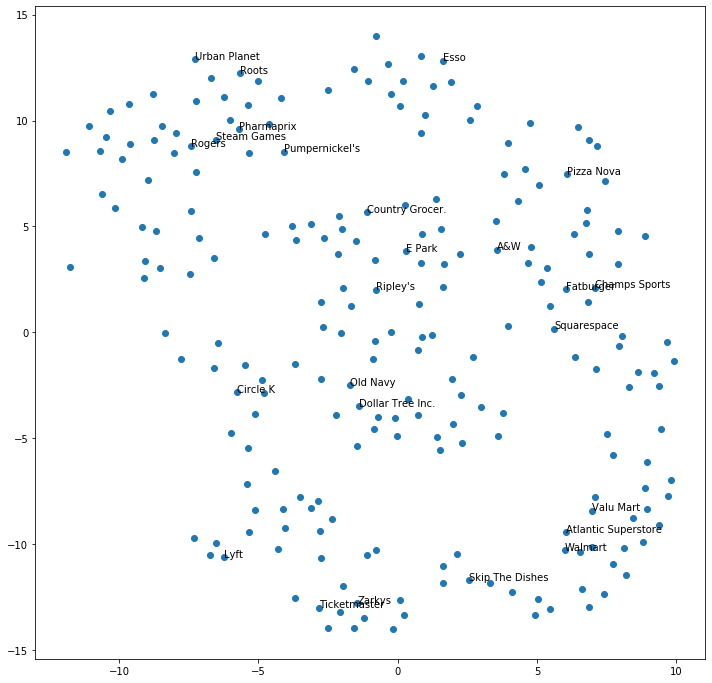

In [99]:
plot_with_matplotlib(x_vals, y_vals, labels)